Author - Andrew W. Jackura

Email - ajackura@odu.edu / ajackura@jlab.org

# Two Particles in a Box

Let us now turn to two particles in a finite cubic volume with side length $L$. In lecture, it is discussed how we can map the discrete spectrum of the two particles to their infinite volume scattereing amplitude. In this notebook, we will explore this concept. We impose periodic boundary conditions, which leads to momentum quantization
$$
\mathbf{p} = \frac{2\pi}{L} \mathbf{n} \, ,
$$
where $\mathbf{n} = [n_{x},n_{y},n_{z}]$ with $n_{x}$, $n_{y}$, and $n_{z}$ being integers.

A single particle will therefore have an energy
$$
E_n = \sqrt{m^2 + \mathbf{p}} = \sqrt{m^2 + \left(\frac{2\pi}{L}\right)^2 \mathbf{n}^2} \, .
$$
For a two-particle system, we find that the total momentum of the system is quantized in a similar fashion. If the particles are free, we also find that each momentum follows the same quantization rule. When the system interacts however, we find that the spectrum shifts by an amount which can be related to the scattering process. This relation is the *Luescher quantizaiton condition*, 
$$
\mathrm{det}\left[ \mathcal{M}^{-1}(s) + F(E,\mathbf{P},L)\right] = 0 \, ,
$$
where $\mathcal{M}$ is the scattering amplitude and $F$ is a finite volume function encoding the geometry of the box. Specifics of this condition will are discussed in the lecture, and in the details below.

#### References

The following papers are milestones in the development of the finite-volume formalism 
* Original Luescher paper (stable particles): <https://inspirehep.net/literature/222569> - Luescher (1985)
* Orginal Luescher paper (scattering): <https://inspirehep.net/literature/231480> - Luescher (1986)
* Non-rest frames: <https://inspirehep.net/literature/393935> - Rummukainen & Gottlieb (1995)
* Field theory approach: <https://inspirehep.net/literature/687104> - Kim, Sharpe, & Sachrajda (2005)
* Coupled-channels: <https://inspirehep.net/literature/1103067> - Hansen & Sharpe (2012)
* Arbitrary number of channels and spin: <https://inspirehep.net/literature/1277082> - Briceno (2014)

(Note: There are many papers on this subject, apologies if I do not refer to a specfic one.)

There is an excellent review on extracting amplitudes from lattice QCD
* *Scattering processes and resonances from lattice QCD*: <https://inspirehep.net/literature/1606083> - Briceno, Dudek, & Young (2018)


In [73]:
'''
Importing useful libraries
'''
import cmath as cm                          # math library (complex)
import math as ma                           # math library
import numpy as np                          # basic functions, linear algebra, etc.
import scipy.special as sp                  # special functions
import numpy.random as rn                   # random numbers
import matplotlib.pyplot as plt             # plotting library
import itertools                            # for creating tuple list
from numpy.core.umath_tests import inner1d  # for fancy dot product with list
from scipy import optimize                  # numerical root finding
from scipy import integrate                 # library for integration
from mpl_toolkits import mplot3d            # for 3d plotting 
from matplotlib.colors import hsv_to_rgb    # convert the color from HSV coordinates to RGB coordinates
from colorsys import hls_to_rgb             # convert the color from HLS coordinates to RGB coordinates    

ipykernel_launcher:11: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


## Free Two-particle Spectrum

The total energy of a two particle system in a box moving with momentum $\mathbf{P}$ is given by the usual energy dispersion relation
$$
E = \sqrt{m^2 + \mathbf{p}^2} + \sqrt{m^2 + (\mathbf{P}-\mathbf{p})^2} \, ,
$$
where $m$ is the mass of the individual particles, $\mathbf{p}$ is the momentum of particle 1, and $\mathbf{P}-\mathbf{p}$ is the momentum of particle 2. Recall from scattering theory that the total center-of-momentum (CM) frame energy $E^{\star}$ is defined as
$$
s = E^{\star\,2} = E^2 - \mathbf{P}^2 \, ,
$$
where $s$ is the Mandelstam invariant.

In a finite volume, all free momenta are quantized, $\mathbf{p} = 2\pi \mathbf{n} / L$ and $\mathbf{P} = 2\pi \mathbf{n}_P / L$ where $\mathbf{n},\mathbf{n}_P \in \mathbb{Z}^3$. Substituting these into the dispersion relation we get
$$
E = \sqrt{m^2 + \left(\frac{2\pi}{L} \right)^2 \mathbf{n}^2} + \sqrt{m^2 + \left(\frac{2\pi}{L} \right)^2(\mathbf{n}_P-\mathbf{n})^2} \, ,
$$
with the CM frame energy being 
$$
E^{\star\,2} = E^2 - \left(\frac{2\pi}{L} \right)^2 \mathbf{n}_P^2 \, .
$$


For a given $\mathbf{n}_P$, we can find the spectrum of two free particles by cycling through all possible $\mathbf{n}$.

<!---
It is useful to express our quantities in terms of a dimensionless mass 
$$
\bar{m} \equiv \frac{mL}{2\pi}\, 
$$
Then, the dispersion relation is simply $E/m  = \sqrt{1 + \mathbf{n}^2 / \bar{m}^2} + \sqrt{1+ (\mathbf{P}-\mathbf{p})^2/ \bar{m}^2}$. Other dimensionless *barred* variables can be defined similarly, e.g. $\bar{E} = EL / 2\pi$. Note that this allows such conversions $E/m = \bar{E}/\bar{m}$.
--->

### Exercises:

1. Enumerate the different momenta (in units of $2\pi / L$) allowed for $\mathbf{n}^2 \in \{0,1,2,3,4,5,6,7,8\}$

2. Take the limit of $E/m$ as $mL \to \infty$

2. Plot the non-interacting spectrum in terms of $E^{\star}/m$ in the rest frame $\mathbf{n}_P = [000]$ as a function of $mL$.

3. Repeat (3) for the frames $\mathbf{n}_P = [001], [011], [111], [002]$.


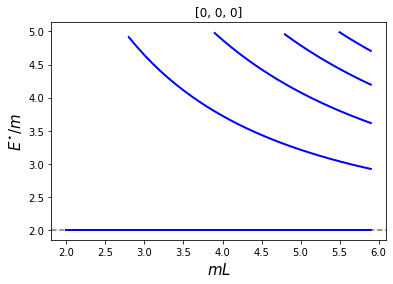

<Figure size 200x100 with 0 Axes>

In [64]:
'''
Free two-particle spectrum
'''

# convenient const
twoPi = 2.0 * np.pi

# unit mass
m = 1.0
m_sq = m * m 

# free two-particle energy 
# n, nP are integer tuples
# L is in units of mass
def free_spectrum( L, n, nP ):
    p1_sq = ( twoPi / L )**2 * np.inner(n,n)        # (2*pi/L)^2 * n^2
    p2_sq = ( twoPi / L )**2 * np.inner(nP-n,nP-n)  # (2*pi/L)^2 * (nP - n)^2
    energy1 = np.sqrt( m_sq + p1_sq )
    energy2 = np.sqrt( m_sq + p2_sq )
    return energy1 + energy2

# generate free spectrum for given L (units of mass), nP, and max energy Ecm_max (units of mass)
def generate_free_spectrum( L, nP, Ecm_max ):
    P_sq = ( twoPi / L )**2 * np.dot(nP,nP)         # (2*pi/L)^2 * nP^2
    n_max = 3.0                                     # max integer for particle momentum
    Energies = []
    intList = np.array(np.arange(-n_max,n_max+1))
    for i in itertools.product(intList,intList,intList):
        n = np.array(i)
        En = free_spectrum(L, n, nP)    # moving frame energy
        Ecm = np.sqrt( En**2 - P_sq )   # convert to CM frame
        Ecm = np.round( Ecm, 10 )
        if Ecm not in Energies:
            if Ecm < Ecm_max:
                Energies.append(Ecm)
    Energies.sort()
    return Energies

# collect free spectra for various L in L_range array into an array of all Ecm and L
def get_spectrum_data( nP, Ecm_max, L_range ):
    data=[]
    level_data = []
    return_data = []
    max_level, level, L_start = 0, 0, 0
    # grab all energies for given L
    for L in L_range:
        Ecm = generate_free_spectrum( L, nP, Ecm_max )
        if len(Ecm) > max_level:
            max_level = len(Ecm)
        data.append(Ecm)

    # combine L_list with energies
    for _ in range(max_level):
        for i in data:
            if len(i) >= level+1:
                level_data.append(i[level])
            else:
                L_start += 1
        return_data.append([L_list[L_start:],level_data.copy()])
        level += 1
        L_start = 0
        level_data.clear()

    return return_data

# routine to plot spectrum as a function of nP and max Ecm
def plot_free_spectrum( nP ):
    L_min, L_max, L_step = 2.0, 6.0, 0.1    # / m
    L_list = np.arange(L_min,L_max,L_step)
    spectrum = get_spectrum_data(nP,Ecm_max,L_list)
    plt.axhline(y=2.0*m, color='gray', linestyle='--') # threshold energy
    for spec in spectrum:
        plt.plot(spec[0],spec[1],color="blue",linewidth=2) # plot each energy level (spec[1]) as a function of L (spec[0])    
    plt.title(str(nP))
    plt.xlabel(r'$mL$',size=15) 
    plt.ylabel(r'$E^{\star}/m$',size=15)
    plt.figure(figsize=(2,1), dpi= 100, facecolor='w', edgecolor='k')

# zero total momentum
nP = [0,0,0]

# max CM energy
Ecm_max = 5.0 # m

# make plot
plot_free_spectrum(nP)

## Finite-volume function

In connecting finite-volume spectra to scattering observables, we naturally encounter a finite-volume function, which we denote as $F(E,\mathbf{P},L)$, which is known colloquially as the Luescher Zeta function (*In fact, our finite-volume function is slightly different from the original Luescher derivation, but they are trivially related through some pre-factors, both encode the same information.*).
This function characterizes the finite-volume distortions an interacting system experiences.

For our purposes, we focus on identical particles in an $S$ wave, and defined the finite-volume function as
$$
F(E,\mathbf{P},L) = \frac{1}{2} \Bigg[\frac{1}{L^3} \sum_{\mathbf{k}\in (2\pi/L)\mathbb{Z}^2} - \int\!\frac{\mathrm{d}^3\mathbf{k}}{(2\pi)^3}\Bigg] \frac{1}{2\omega_k} \frac{1}{E^{\star}(E^{\star} - 2\omega_{k}+i\epsilon)} \, .
$$
As discussed in the lectures, we can simplify this function for numerical evaluation. We find the convenient form 
$$
\begin{align}
F(E,\mathbf{P},L) & = i\rho + \frac{\xi}{2E^{\star}} \frac{1}{L^{3}} \sum_{\mathbf{k}} \frac{\omega_{k}^{\star}}{\omega_{k}} \, \frac{e^{-\alpha(k^{\star\,2} - q^{\star\,2})}}{q^{\star\,2} - k^{\star\,2}} + \frac{\xi}{4\pi^2 E^{\star}}\Big[ \sqrt{\frac{\pi}{4\alpha}} e^{\alpha q^{\star\,2}} - \frac{\pi q^{\star}}{2} \mathrm{erfi}(\sqrt{\alpha q^{\star\,2}}) \Big] \, , \\[5pt]
%
& \equiv i\rho + F_{\mathrm{pv}}(E,\mathbf{P},L)
\end{align}
$$
where $\rho$ and $q^{\star}$ are as defined from our scattering theory discussion, and we have introduced the $\alpha$ regulation to tame the UV divergence, assuming that formally we must take the limit as $\alpha \to 0$. Practically, we find we only need a small value to find sufficient convergent to our desired precision. It is also convenient to introduce a dimensionless $\widetilde{\alpha} = (2\pi / L)^2 \alpha$.

### Exercises

1. Derive $F(E,\mathbf{P},L)$ using the all-orders approach discussed in the lectures. Additionally, simplify the result to the one useful for numerical computation

2. What are the dimensions of $F$?

3. For a system at total momentum $\mathbf{P} = \mathbf{0}$, plot $F$ as a function of $E^{\star}/m$, $(Lq^{\star}/2\pi)$ for fixed $mL = 4, 5$, and 6.

4. Repeat (3) for moving frame systems, $\mathbf{n}_P = [001], [011], [111], [002]$.

In [283]:
'''
Finite-volume function
'''

# Let us work with ideentical particles throughout
xi = 0.5 # symmetry factor

# sqrt with branch cut aligned on positive real axis
def mySqrt(z):
   return 1j * np.sqrt( -z )

# CM momentum
def q_cm(s):
    return 0.5 * mySqrt( s - 4.0 * m**2 )

# Phase space factor
def phase_space(s):
    return xi * q_cm(s) / ( 8.0 * np.pi * np.sqrt(s) )

# inner product for two list (native)
def dot(A, B):
   return np.dot(A,B) #inner1d(A,B) #np.sum( A * B, axis=1) 

# Function to generate 3-tuple "n = (nx,ny,nz)" list 
# subject to the constraint nx^2 + ny^2 + nz^2 <= nShell^2,
# where "nShell" indicates the number of shells
def generateIntList( nShell ):
    intList = []
    rawList = np.array(np.arange(-nShell,nShell+1))
    for i in itertools.product(rawList,rawList,rawList):
        tmpList = np.array(i)
        if ( np.dot(tmpList,tmpList) <= nShell*nShell ):
            intList.append(tmpList)

    return np.asarray(intList)

# returns the unit vector of a vector "A"
def unit_vector( A ):
    if( all( A==0 ) ):
        return A
    else:
        return A / np.sqrt( np.dot(A,A) )

# special multiply for array of arrays (A) and an array (B), used in the zeta function
def multiply( A, B ):
   nA = len(A)
   return A.reshape(nA,1) * np.tile( B, (nA,1) )
   ### First, reshape A array to 2d (1xnA), and then copy b vector nA time to make (nA x nB) array
   ### alternatively, do (A.reshape(nA,1)).dot( B.reshape(1,3) ) 

# returns a Lorentz boosted four vector "(A0,A)" given some boost velocity "beta"
def lorentzBoost( A0, A, beta ):
    gamma = 1.0 / np.sqrt( 1.0 - np.dot(beta,beta) )
    Apar  = multiply( A.dot( unit_vector(beta) ), unit_vector(beta) )
    Aper  = A - Apar
    A0_prime = gamma * ( A0 - A.dot( beta ) )
    A_prime  = gamma * ( Apar - multiply( A0, beta ) ) + Aper
    return A0_prime, A_prime


# cutoff function (alpha input is dimensionless)
def cutoff( qcm_sq, kcm_sq, alpha, L ):
    alpha = (L / twoPi)**2 * alpha  # convert to dimensionfull units
    return np.exp( -alpha * ( kcm_sq - qcm_sq ) )

#
# KSS Zeta function for ell = m_ell = 0, given "qcm_sq", total momentum "nP"
# This function is in units of L / 2pi, e.g. m1 -> m1 * L / (2 * pi).
#

# Finite volume function F, given Ecm (units of mass), nP, alpha (dimensionless), and L (units of mass)
# MUST call generateIntList first and use global intList from its output
#
# Note: We chose to have Ecm as input rather than E for convenience in plotting/ pole finding. Coding it the other way works too, 
# we are just saving ourselves a couple transformations which are not needed for our purposes.
#
def F_function( Ecm, nP, alpha, L ):
    P = twoPi *nP / L                               # P = (2*pi/L)* nP
    P_sq = np.dot(P,P)                              # P^2
    E = np.sqrt( Ecm**2 + P_sq )                    # compute E given Ecm and P
    s = Ecm**2
    eps = 1e-16
    qcm = q_cm(s+1j*eps)
    qcm_sq = qcm**2
    rho = phase_space(s+1j*eps)
    beta = P/E                                      # boost velocity

    k = (twoPi / L) * intList
    omega = np.sqrt( m_sq + inner1d(k,k) )
    omega_cm, k_cm = lorentzBoost( omega, k, beta )
    tmp = cutoff( qcm_sq, inner1d(k_cm,k_cm), alpha, L ) * omega_cm / omega
    tmp = tmp / ( qcm_sq - inner1d(k_cm,k_cm ) ) 
    sum0 = ( xi / (2.0 * Ecm * L**3) ) * np.sum( tmp )

    z   = np.sqrt( alpha ) * qcm
    integral = ( xi / (4.0 * np.pi**2 * Ecm )) * ( ( np.sqrt( 0.25 * np.pi / alpha ) ) * np.exp( alpha * qcm_sq ) - 0.5 * np.pi * qcm * sp.erfi( z ) )
    
    return  1j * rho + sum0.real + integral # taking real part of sum to remove imaginary artifact at threshold


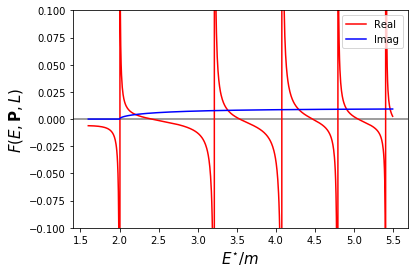

In [298]:
'''
Making some plots of F
'''

# number of shells for sum, nshell^2 = nx^2 + ny^2 + nz^2
nShell = 20

# dimensionless alpha regulator
alpha = 0.125   # can tune this more carefully to ensure convergence is what is desired. Here, 0.125 with nShell = 20 is sufficient

# generating integer tuple
intList = generateIntList( nShell )

L = 5.0 # / m
nP = np.array([0,0,0])

# plot routine for F
# Note: because of the way I coded the F function, I need to loop through the energies and append an array instead of passing and array. 
# If you find a better alternative for this code or the code above, please let me know.
def plot_F(L, nP):
    F_list = []
    Ecm_o_m_start, Ecm_o_m_stop, Ecm_o_m_step = 1.6, 5.5, 0.005
    Ecm_o_m_range = np.arange(Ecm_o_m_start, Ecm_o_m_stop, Ecm_o_m_step)
    for Ecm_o_m in Ecm_o_m_range:
        F_list.append(F_function( Ecm_o_m, nP, alpha, L ))
    F = np.asarray(F_list)
    plt.axhline(y=0, color='gray', linestyle='-') 
    plt.plot(Ecm_o_m_range, F.real, color='red',label="Real")
    plt.plot(Ecm_o_m_range, F.imag, color='blue',label="Imag")
    plt.xlabel(r'$E^{\star}/m$',fontsize=15)
    plt.ylabel(r'$F(E,\mathbf{P},L)$',fontsize=15)
    plt.legend(loc="upper right")
    plt.ylim(-0.1,0.1)

plot_F(L,nP)

## Connecting the finite-volume function to the spectrum

One can show that in the absence of interactions, the spectrum of two particles can be determined by looking at
$$
F^{-1}(E_{\mathfrak{n}},\mathbf{P},L) = 0 \, .
$$
Note that we can also find the spectrum by looking only at the principle value piece, $F_{\mathrm{pv}}^{-1} = 0$, since the phase space factor does not exhibit the finite-volume pole behavior. One can of course look at the simultaneous zero of both the real and the imaginary part, which is often done for more complicated interacting systems where we cannot remove the imaginary part entirely.

### Exercise:

1. Find the spectrum of two non-interacting particles in their rest frame by solving $F^{-1} = 0$ for fixed $mL = 4, 5$, and 6

2. Repeat (1) for moving frame systems, $\mathbf{n}_P = [001], [011], [111], [002]$.

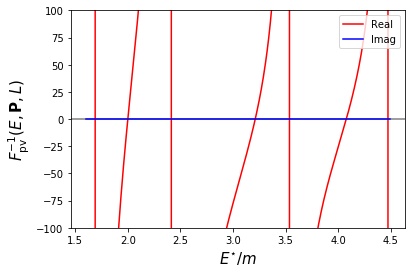

In [299]:
# first, take a look at F^{-1}

# let's define a PV version (will be useful later)
def Fpv_function( Ecm, nP, alpha, L ):
    s = Ecm**2
    eps = 1e-16
    rho = phase_space(s+1j*eps)
    return F_function( Ecm, nP, alpha, L ) - 1j * rho

# plot inverse of Fpv
def plot_Finv(L, nP):
    Finv_list = []
    Ecm_o_m_start, Ecm_o_m_stop, Ecm_o_m_step = 1.6, 4.5, 0.005
    Ecm_o_m_range = np.arange(Ecm_o_m_start, Ecm_o_m_stop, Ecm_o_m_step)
    for Ecm_o_m in Ecm_o_m_range:
        Finv_list.append(1.0 / Fpv_function( Ecm_o_m, nP, alpha, L ))
    Finv = np.asarray(Finv_list)
    plt.axhline(y=0, color='gray', linestyle='-') 
    plt.plot(Ecm_o_m_range, Finv.real, color='red',label="Real")
    plt.plot(Ecm_o_m_range, Finv.imag, color='blue',label="Imag")
    plt.xlabel(r'$E^{\star}/m$',fontsize=15)
    plt.ylabel(r'$F_{\mathrm{pv}}^{-1}(E,\mathbf{P},L)$',fontsize=15)
    plt.legend(loc="upper right")
    plt.ylim(-100,100)

# make plot
plot_Finv(L,nP)

In [286]:

# steps through a kinematic region to look for roots
# if a candidate is found, it is saved
# once all candidates all found, it then uses the brent method to search for root
def root_stepper( nP, alpha, L ):
    Ecm_candidate = []
    Ecm_spectrum = []
    F_inv = lambda Ecm: 1.0 / Fpv_function( Ecm, nP, alpha, L ).real
    Ecm_o_m_start, Ecm_o_m_stop, Ecm_o_m_step = 1.8, 5.2, 0.005              # May need to play around with step to ensure resolution is good
    Ecm_o_m_range = np.arange(Ecm_o_m_start, Ecm_o_m_stop, Ecm_o_m_step)
    print('looking for candidates')
    for Ecm_o_m in Ecm_o_m_range:
        a = Ecm_o_m
        b = Ecm_o_m + Ecm_o_m_step
        if ( F_inv(a) * F_inv(b) < 0 ):
            print('found candidate near = ', a)
            Ecm_candidate.append(a)

    print(' ')
    print('looking for roots')
    tol = 1e-5  # tolerance parameter to check if zero of asymptote
    for Ecm_o_m in Ecm_candidate:
        Ecm_spec = optimize.brentq(F_inv, Ecm_o_m, Ecm_o_m+Ecm_o_m_step)
        if ( np.abs(F_inv(Ecm_spec)) < tol ):
            print('found root at Ecm = ', Ecm_spec, 'with |F^{-1}| (Ecm_root) = ', np.abs(F_inv(Ecm_spec)))
            Ecm_spectrum.append(Ecm_spec)

    return Ecm_spectrum

# save roots found
Ecm_from_F = root_stepper(nP,alpha,L)

looking for candidates
found candidate near =  1.9999999999999958
found candidate near =  2.409999999999987
found candidate near =  3.2099999999999698
found candidate near =  3.534999999999963
found candidate near =  4.074999999999951
found candidate near =  4.469999999999943
found candidate near =  4.789999999999936
found candidate near =  5.0499999999999305
 
looking for roots
found root at Ecm =  1.9999999999999958 with |F^{-1}| (Ecm_root) =  4.218995638300198e-12
found root at Ecm =  3.2119381713704183 with |F^{-1}| (Ecm_root) =  6.127521185048806e-10
found root at Ecm =  4.078368991814544 with |F^{-1}| (Ecm_root) =  7.570414404736916e-14
found root at Ecm =  4.7905783001743565 with |F^{-1}| (Ecm_root) =  7.384890444139908e-10


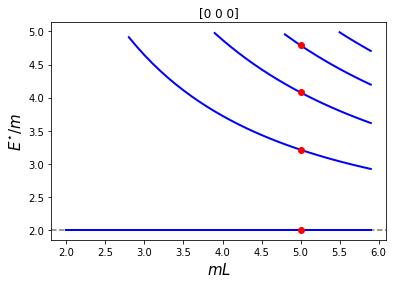

<Figure size 200x100 with 0 Axes>

In [287]:
# Let us check to make sure it matches from before
def plot_free_spectrum_F( nP ):
    L_min, L_max, L_step = 2.0, 6.0, 0.1    # / m
    L_list = np.arange(L_min,L_max,L_step)
    spectrum = get_spectrum_data(nP,Ecm_max,L_list)
    plt.axhline(y=2.0*m, color='gray', linestyle='--') # threshold energy
    for spec in spectrum:
        plt.plot(spec[0],spec[1],color="blue",linewidth=2) # plot each energy level (spec[1]) as a function of L (spec[0])    
    plt.plot([L]*len(Ecm_from_F),Ecm_from_F,'ro')
    plt.title(str(nP))
    plt.xlabel(r'$mL$',size=15) 
    plt.ylabel(r'$E^{\star}/m$',size=15)
    plt.figure(figsize=(2,1), dpi= 100, facecolor='w', edgecolor='k')

plot_free_spectrum_F( nP )

## Luescher Quantization Condition

If we now turn on interactions between particles, we found that the poles of the correlation matrix (which correspond to the energy spectrum), are fixed by the *Luescher quantization condition*
$$
\mathrm{det}\!\left[ \, \mathcal{M}^{-1}(s_{\mathfrak{n}}) + F(E_{\mathfrak{n}},\mathbf{P},L) \, \right] = 0
$$
In principle, this is a determinant over the infinite-dimensional angular momentum space. However, we may truncate this condition by noting that scattering amplitudes exhibit an angular momentum barrier suppression $\mathcal{M}_{\ell}(s) \sim q^{\star\,2\ell}$. Therefore, in a limited energy region near threshold (where the quantization is well-defined), we may cut the angular momentum at some $\ell < \ell_{\mathrm{max}}$.

In the following, we consider a system which is dominated by $S$ wave scattering, reducing the determinant condition to a single scalar equation
$$
\mathcal{M}^{-1}(s_{\mathfrak{n}}) + F(E_{\mathfrak{n}},\mathbf{P},L) = 0 \, .
$$
We may further simplify the expression by pulling the imaginary part from $F$ and $\mathcal{M}$, yielding a real equation
$$
\mathcal{K}^{-1}(E_{\mathfrak{n}}^{\star}) + F_{\mathrm{pv}}(E_{\mathfrak{n}},\mathbf{P};L) = 0
$$

In practical lattice QCD calculations, we obtain the spectrum via the GEVP, and use the condition to constrain the $K$ matrix (or scattering amplitude). Once the $K$ matrix is determined, we can then use our scattering theory to understand the hadronic spectrum. In this notebook, we will do the reverse - We will insert a parameterization for the $K$ matrix, and see how the spectrum reacts to the two-body interactions.

### Exercises:

1. Show that the imaginary parts of $\mathcal{M}^{-1}$ and $F$ cancel

1. Using the Breit-Wigner and Effective Range parameterizations, investigate the spectrum of an interacting two-particle system.

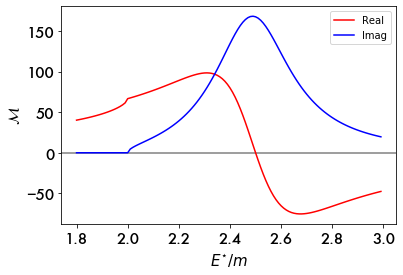

<Figure size 200x100 with 0 Axes>

In [307]:
'''
Reminding ourselves of the amplitudes
'''

# General amplitude function
def Amplitude( s, Kmatrix ):
    K = Kmatrix(s)
    rho = phase_space(s)
    return K / ( 1.0 - 1j * rho * K )

# K-matrix for Breit-Wigner parameterization
def Kmatrix_BreitWigner( s, m0, g0 ):
    Gamma = g0**2 * m0**2 * q_cm(s) / ( 6.0 * np.pi * s )
    tanDelta = np.sqrt( s ) * Gamma / ( m0**2 - s )
    rho = phase_space(s)
    return tanDelta / rho

# K-matrix for 2-parameter Effective Range parameterization
def Kmatrix_EffectiveRange( s, a, r ):
    qCotDelta = -1.0 / a + 0.5 * r * q_cm( s )**2
    return ( 8.0 * np.pi * np.sqrt(s) / xi ) / qCotDelta

# Routine to plot amplitude
def plot_amplitude( Kmatrix ):
    eps = 1e-16                                                 # shift s value slightly above real axis
    Ecm_o_m = np.arange(1.8, 3, 0.01)                           # array of Ecm / m
    amp = Amplitude( Ecm_o_m**2+1j*eps, Kmatrix )
    plt.axhline(y=0.0, color='gray', linestyle='-')
    plt.plot(Ecm_o_m, amp.real, color='red',label="Real")
    plt.plot(Ecm_o_m, amp.imag, color='blue',label="Imag")
    plt.xlabel(r'$E^{\star} / m$',size=15)
    plt.ylabel(r'$\mathcal{M}$',size=15)
    plt.xticks(fontname="Futura",fontsize=15)
    plt.yticks(fontname="Futura",fontsize=15)
    plt.legend(loc="upper right")
    plt.figure(figsize=(2,1), dpi= 100, facecolor='w', edgecolor='k')

# Sample Effective Range parameters
a = 2.0 # /m
r = 0.0 # /m

# Sample Breit-Wigner parameters
m0 = 2.5 # m
g0 = 3.0

# Plot Breit-Wigner amplitude
plot_amplitude( lambda s:Kmatrix_BreitWigner(s,m0,g0) )

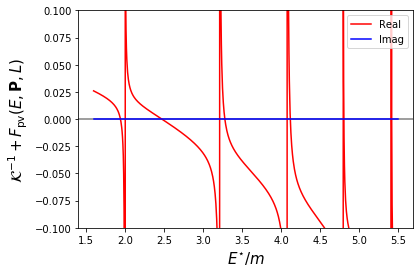

In [302]:
'''
Luescher Quantization Condition
'''

# define quantization condition with K matrix input
def quantization_condition( Ecm, nP, L, Kmatrix ):
    eps = 1e-16
    s = Ecm**2 + 1j*eps
    Kmat = Kmatrix(s)
    Fpv = Fpv_function( Ecm, nP, alpha, L )
    return 1.0 / Kmat + Fpv 

# plot quantization condition
def plot_QC(L, nP):
    QC_list = []
    Kmat = lambda s: Kmatrix_BreitWigner( s, m0, g0 )
    Ecm_o_m_start, Ecm_o_m_stop, Ecm_o_m_step = 1.6, 5.5, 0.005
    Ecm_o_m_range = np.arange(Ecm_o_m_start, Ecm_o_m_stop, Ecm_o_m_step)
    for Ecm_o_m in Ecm_o_m_range:
        QC_list.append(quantization_condition( Ecm_o_m, nP, L, Kmat ))
    QC = np.asarray(QC_list)
    plt.axhline(y=0, color='gray', linestyle='-') 
    plt.plot(Ecm_o_m_range, QC.real, color='red',label="Real")
    plt.plot(Ecm_o_m_range, QC.imag, color='blue',label="Imag")
    plt.xlabel(r'$E^{\star}/m$',fontsize=15)
    plt.ylabel(r'$\mathcal{K}^{-1} + F_{\mathrm{pv}}(E,\mathbf{P},L)$',fontsize=15)
    plt.legend(loc="upper right")
    plt.ylim(-0.1,0.1)

# make plot
plot_QC(L,nP)

In [313]:
# steps through a kinematic region to look for roots
# if a candidate is found, it is saved
# once all candidates all found, it then uses the brent method to search for root
def root_stepper_QC( nP, L ):
    Ecm_candidate = []
    Ecm_spectrum = []
    Kmat = lambda s: Kmatrix_BreitWigner( s, m0, g0 )
    QC = lambda Ecm: quantization_condition( Ecm, nP, L, Kmat )
    Ecm_o_m_start, Ecm_o_m_stop, Ecm_o_m_step = 1.6, 5.2, 0.01              # May need to play around with step to ensure resolution is good
    Ecm_o_m_range = np.arange(Ecm_o_m_start, Ecm_o_m_stop, Ecm_o_m_step)
    print('looking for candidates')
    for Ecm_o_m in Ecm_o_m_range:
        a = Ecm_o_m
        b = Ecm_o_m + Ecm_o_m_step
        if ( QC(a) * QC(b) < 0.0 ):
            print('found candidate near = ', a)
            Ecm_candidate.append(a)

    print(' ')
    print('looking for roots')
    tol = 1e-5  # tolerance parameter to check if zero of asymptote
    for Ecm_o_m in Ecm_candidate:
        Ecm_spec = optimize.brentq(QC, Ecm_o_m, Ecm_o_m+Ecm_o_m_step)
        if ( np.abs(QC(Ecm_spec)) < tol ):
            print('found root at Ecm = ', Ecm_spec, 'with |K^{-1}+Fpv| (Ecm_root) = ', np.abs(QC(Ecm_spec)) )
            Ecm_spectrum.append(Ecm_spec)

    return Ecm_spectrum

L = 5.0 # m

# save roots found
Ecm_BreitWigner = root_stepper_QC(nP,L)

looking for candidates
found candidate near =  1.9400000000000004
found candidate near =  1.9900000000000004
found candidate near =  2.4700000000000006
found candidate near =  3.2100000000000017
found candidate near =  3.2700000000000014
found candidate near =  4.070000000000002
found candidate near =  4.110000000000003
found candidate near =  4.790000000000003
found candidate near =  4.8000000000000025
 
looking for roots
found root at Ecm =  1.943568986035758 with |K^{-1}+Fpv| (Ecm_root) =  1.2952833250622398e-13
/Users/andrewjackura/opt/anaconda3/envs/python3/lib/python3.7/site-packages/scipy/optimize/zeros.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  r = _zeros._brentq(f, a, b, xtol, rtol, maxiter, args, full_output, disp)
found root at Ecm =  2.4730575955829046 with |K^{-1}+Fpv| (Ecm_root) =  8.266861444825344e-18
found root at Ecm =  3.279888404523668 with |K^{-1}+Fpv| (Ecm_root) =  2.642261409677244e-13
found root at Ecm =  4.1173817781902

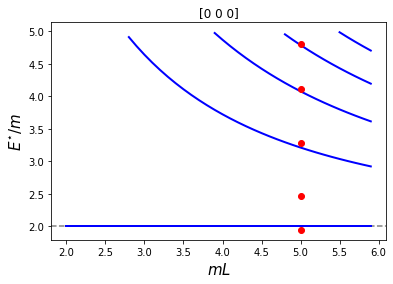

<Figure size 200x100 with 0 Axes>

In [326]:
# Let us check the spectrum
L = 5.0
def plot_interacting_spectrum( nP ):
    L_min, L_max, L_step = 2.0, 6.0, 0.1    # / m
    L_list = np.arange(L_min,L_max,L_step)
    spectrum = get_spectrum_data(nP,Ecm_max,L_list)
    plt.axhline(y=2.0*m, color='gray', linestyle='--') # threshold energy
    for spec in spectrum:
        plt.plot(spec[0],spec[1],color="blue",linewidth=2) # plot each energy level (spec[1]) as a function of L (spec[0])    
    plt.plot([L]*len(Ecm_BreitWigner),Ecm_BreitWigner,'ro')
    plt.title(str(nP))
    plt.xlabel(r'$mL$',size=15) 
    plt.ylabel(r'$E^{\star}/m$',size=15)
    plt.figure(figsize=(2,1), dpi= 100, facecolor='w', edgecolor='k')

plot_interacting_spectrum( nP )

In [316]:
# Let's look at L dependence (this takes a little while)

Ecm_BreitWigner_L = []
L_int = [2,2.5,3,3.5,4,4.5,5,5.5,6]
for L in L_int:
    Ecm_BreitWigner_L.append(root_stepper_QC(nP,L))



looking for candidates
found candidate near =  1.9900000000000004
found candidate near =  2.5500000000000007
 
looking for roots
/Users/andrewjackura/opt/anaconda3/envs/python3/lib/python3.7/site-packages/scipy/optimize/zeros.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  r = _zeros._brentq(f, a, b, xtol, rtol, maxiter, args, full_output, disp)
found root at Ecm =  2.553673886664132 with |K^{-1}+Fpv| (Ecm_root) =  3.361687843308273e-17
looking for candidates
found candidate near =  1.9900000000000004
found candidate near =  2.480000000000001
 
looking for roots
found root at Ecm =  2.485620897371504 with |K^{-1}+Fpv| (Ecm_root) =  1.3731350596314405e-17
looking for candidates
found candidate near =  1.61
found candidate near =  1.9900000000000004
found candidate near =  2.450000000000001
found candidate near =  4.640000000000002
found candidate near =  4.680000000000003
 
looking for roots
found root at Ecm =  1.6155786777276244 with |K^{-1}+Fpv| (

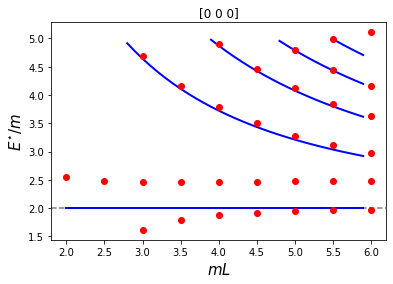

<Figure size 200x100 with 0 Axes>

In [331]:
# Let us check the spectrum
def plot_interacting_spectrum_L( nP ):
    L_min, L_max, L_step = 2.0, 6.0, 0.1    # / m
    L_list = np.arange(L_min,L_max,L_step)
    spectrum = get_spectrum_data(nP,Ecm_max,L_list)
    plt.axhline(y=2.0*m, color='gray', linestyle='--') # threshold energy
    for spec in spectrum:
        plt.plot(spec[0],spec[1],color="blue",linewidth=2) # plot each energy level (spec[1]) as a function of L (spec[0])  
    for i,L in enumerate(L_int):  
        plt.plot([L]*len(Ecm_BreitWigner_L[i]),Ecm_BreitWigner_L[i],'ro')
    plt.title(str(nP))
    plt.xlabel(r'$mL$',size=15) 
    plt.ylabel(r'$E^{\star}/m$',size=15)
    plt.figure(figsize=(2,1), dpi= 100, facecolor='w', edgecolor='k')

plot_interacting_spectrum_L( nP )